In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [4]:
# load client and invoice datasets
client_train = pd.read_csv('data/client_train.csv')
client_test = pd.read_csv('data/client_test.csv')

invoice_train = pd.read_parquet('data/invoice_train_compressed.csv.parquet')
invoice_test = pd.read_parquet('data/invoice_test_compressed.csv.parquet')

In [5]:
# merge client and invoice training and testing dataset
merged_df = pd.merge(invoice_train, client_train, on='client_id', how='inner')

merged_test = pd.merge(invoice_test, client_test, on='client_id', how='inner')

In [6]:
from sklearn.preprocessing import LabelEncoder

# Define the list of categorical columns
categorical_columns = ['disrict', 'client_catg', 'region', 'tarif_type', 
                       'counter_statue', 'reading_remarque', 'counter_type']
'''
# Apply Label Encoding to each categorical feature
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col].astype(str))  # Convert to string in case there are mixed types
    label_encoders[col] = le  # Store the encoder for potential inverse_transform
'''
# Apply One-Hot Encoding
merged_df = pd.get_dummies(merged_df, columns=categorical_columns, drop_first=True)

# Print the first few rows to verify the new one-hot encoded columns
print("One-hot encoded dataset:")
print(merged_df.head())

One-hot encoded dataset:
        client_id invoice_date  counter_number  counter_code  \
0  train_Client_0   2014-03-24         1335667           203   
1  train_Client_0   2013-03-29         1335667           203   
2  train_Client_0   2015-03-23         1335667           203   
3  train_Client_0   2015-07-13         1335667           207   
4  train_Client_0   2016-11-17         1335667           207   

   counter_coefficient  consommation_level_1  consommation_level_2  \
0                    1                    82                     0   
1                    1                  1200                   184   
2                    1                   123                     0   
3                    1                   102                     0   
4                    1                   572                     0   

   consommation_level_3  consommation_level_4  old_index  ...  \
0                     0                     0      14302  ...   
1                     0                

Fraud detection data contains categorical features (e.g., district, client category). Machine learning models like kNN require numerical inputs so label encoding was used to convert these categorical features into numerical representations without introducing ordinal relationships (since the categories aren't inherently ordered), which ensures that the data can be utilized effectively by the kNN algorithm.

In [7]:
# Exclude irrelevant columns (like 'client_id', 'invoice_date', etc.) and the target column
irrelevant_columns = ['client_id', 'invoice_date', 'creation_date', 'target']
features = [col for col in merged_df.columns if col not in irrelevant_columns]

In [8]:
from sklearn.model_selection import train_test_split

# Partion the features from the class to predict
df_X = merged_df[features]
df_y = merged_df['target'].astype(int)  # Convert 'target' to integer (1/0)  # Convert 'Fraud'/'Not Fraud' to 1/0

# Split the training data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=1)

print ("Number of training instances: ", len(X_train), "\nNumber of test instances: ", len(X_test))

Number of training instances:  3133724 
Number of test instances:  1343025


In [9]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

kNN relies on distance metrics (e.g., Euclidean, Manhattan). Features with large scales can dominate the distance calculations. StandardScaler was applied to normalize features to have zero mean and unit variance. Standardization prevents bias due to differing feature scales and improves the accuracy of distance-based methods like kNN.

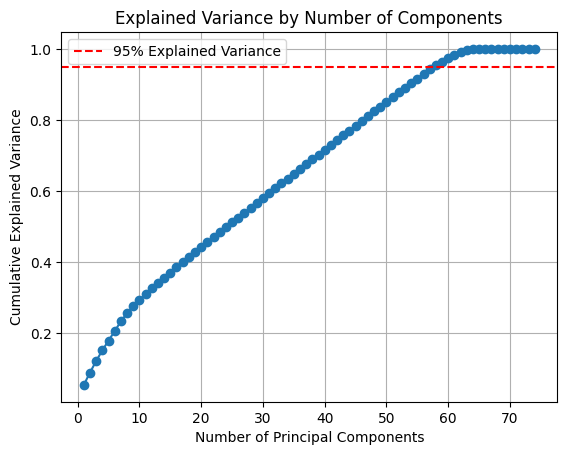

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Fit PCA on the full dataset or a sample
pca = PCA().fit(X_train_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Assuming `cumulative_variance` is the array of cumulative explained variance ratios
threshold = 0.95  # 95% explained variance
optimal_n_components = np.argmax(cumulative_variance >= threshold) + 1  # +1 since indices start at 0

print(f"The optimal number of components to retain 95% variance is: {optimal_n_components}")

The optimal number of components to retain 95% variance is: 58


In [12]:
# Apply PCA with a fixed number of components 
pca = PCA(n_components=58, random_state=1)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Number of PCA components: {X_train_pca.shape[1]}")

Number of PCA components: 58


High-dimensional data can cause the "curse of dimensionality," making distances less meaningful and increasing computational complexity.
PCA reduces the dimensionality while retaining 95% of the variance in the data. Reducing the number of features improves kNN's runtime efficiency without significantly sacrificing predictive performance. PCA also helps in identifying latent patterns and makes the data more compact, aiding in better model performance.

In [13]:
# Check the class distribution in the training set
print("Number of training instances: ")
print(len(X_train_pca))

class_distribution = y_train.value_counts(normalize=True)

print("Class distribution in the training set:")
print(class_distribution)


Number of training instances: 
3133724
Class distribution in the training set:
target
0    0.92107
1    0.07893
Name: proportion, dtype: float64


In [14]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

print("Number of training instances after SMOTE: ")
print(len(X_train_resampled))

print("Class distribution in resampled training set:")
print(y_train_resampled.value_counts(normalize=True))

/Users/Berniss/Downloads/CS3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Number of training instances after SMOTE: 
5772760
Class distribution in resampled training set:
target
0    0.5
1    0.5
Name: proportion, dtype: float64


In [15]:
# Reshape data for RNN input (samples, time steps, features)
X_train_rnn = np.reshape(X_train_resampled, (X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))
X_test_rnn = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [17]:
model = Sequential([
    LSTM(128, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/Users/Berniss/Downloads/CS3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
# Train the model
history = model.fit(
    X_train_rnn, y_train_resampled,
    validation_split=0.2,
    epochs=5,
    batch_size=128,
    verbose=1
)

Epoch 1/5
36080/36080 ━━━━━━━━━━━━━━━━━━━━ 251s 7ms/step - accuracy: 0.6666 - loss: 0.6096 - val_accuracy: 0.2961 - val_loss: 0.8892
Epoch 2/5
36080/36080 ━━━━━━━━━━━━━━━━━━━━ 296s 8ms/step - accuracy: 0.6674 - loss: 0.6084 - val_accuracy: 0.2865 - val_loss: 0.8783
Epoch 3/5
36080/36080 ━━━━━━━━━━━━━━━━━━━━ 292s 8ms/step - accuracy: 0.6683 - loss: 0.6075 - val_accuracy: 0.3214 - val_loss: 0.8791
Epoch 4/5
36080/36080 ━━━━━━━━━━━━━━━━━━━━ 257s 7ms/step - accuracy: 0.6689 - loss: 0.6065 - val_accuracy: 0.3151 - val_loss: 0.8717
Epoch 5/5
36080/36080 ━━━━━━━━━━━━━━━━━━━━ 237s 7ms/step - accuracy: 0.6695 - loss: 0.6058 - val_accuracy: 0.3546 - val_loss: 0.8459


In [24]:
# Apply PCA to the test set after fitting it on the training set
X_test_pca = pca.transform(X_test_scaled)

# Reshape PCA-transformed data for the LSTM model
X_train_rnn = np.reshape(X_train_resampled, (X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))
X_test_rnn = np.reshape(X_test_pca, (X_test_pca.shape[0], 1, X_test_pca.shape[1]))

print("Shapes after reshaping:")
print("X_train_rnn shape:", X_train_rnn.shape)
print("X_test_rnn shape:", X_test_rnn.shape)

Shapes after reshaping:
X_train_rnn shape: (5772760, 1, 58)
X_test_rnn shape: (1343025, 1, 58)


In [25]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model
y_pred = (model.predict(X_test_rnn) > 0.5).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

41970/41970 ━━━━━━━━━━━━━━━━━━━━ 75s 2ms/step
Confusion Matrix:
 [[1068719  168538]
 [  68905   36863]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90   1237257
           1       0.18      0.35      0.24    105768

    accuracy                           0.82   1343025
   macro avg       0.56      0.61      0.57   1343025
weighted avg       0.88      0.82      0.85   1343025



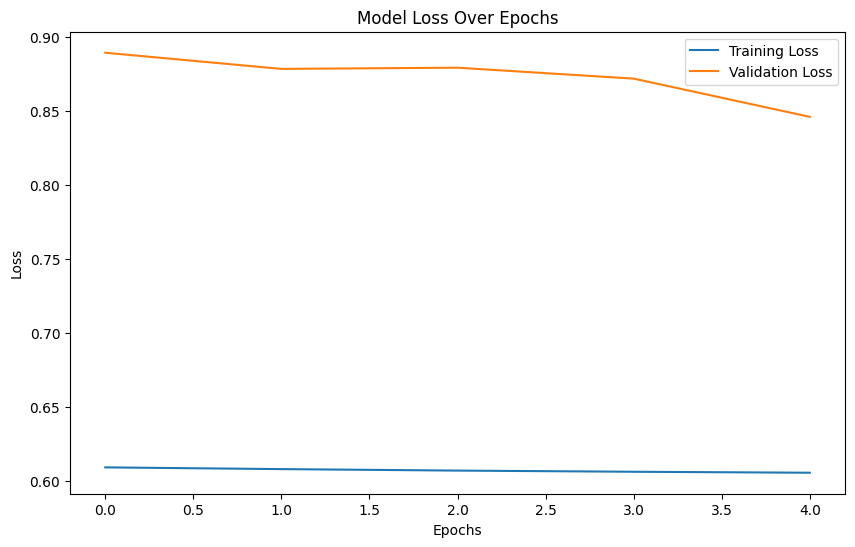

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
data = pd.read_csv('output.csv')

In [ ]:
mapping = {
    0:0,
    1:1,
    5:5,
    4:4,
    3:3,
    2:2,
    769:5,
    '0':0,
    '5':5,
    '1':1,
    '4':4,
    'A':0,
    618:5,
    269375:5,
    46:5,
    420:5
}

data['counter_statue'] = data['counter_statue'].replace(mapping)
data['counter_statue'].unique()

In [ ]:
mapping_2 = {
    'ELEC':0,
    'GAZ':1,
}

data['counter_type'] = data['counter_type'].replace(mapping_2)
data['counter_type'].unique()

In [ ]:
data['creation_date'] = pd.to_datetime(data['creation_date'])
data['invoice_date'] = pd.to_datetime(data['invoice_date'])

In [ ]:
non_ordinal_categorical = ['disrict', 'client_catg',
                            'region', 'tarif_type', 
                            'counter_statue', 'counter_code', 
                            'reading_remarque', 'counter_type',
                            'counter_coefficient']

data = pd.get_dummies(data, columns=non_ordinal_categorical)

In [ ]:
ordinal_categorical = ['counter_number', 'new_index', 'months_number']

for col in ordinal_categorical:
    counts = data[col].value_counts()
    print(counts)

In [ ]:
continuous_features = ['consommation_level_1', 'consommation_level_2',
                       'consommation_level_3', 'consommation_level_4',
                       'creation_date_year', 'creation_date_month',
                       'creation_date_day', 'invoice_date_year',
                       'invoice_date_month', 'invoice_date_day']

scaler = StandardScaler()
data[continuous_features] = scaler.fit_transform(data[continuous_features])
data[continuous_features]

In [ ]:
data.drop(columns='client_id', inplace=True)

In [ ]:
data['days_between_creation_and_invoice'] = (data['invoice_date'] - data['creation_date']).dt.days
data['days_since_last_invoice'] = data['invoice_date'].diff().dt.days.fillna(0)

In [ ]:
data.drop(columns=[
    'invoice_date', 'creation_date'
], inplace=True)

In [ ]:
seq_features = ['days_since_last_invoice', 'days_between_creation_and_invoice']
static_features = [col for col in data.columns if col not in seq_features + ['target']]

sequential_data = data[seq_features].values.reshape(-1, 1, len(seq_features))  # Sequential data
static_data = data[static_features].values  # Static data
labels = data['target'].values  # Target variable

In [ ]:
sequential_data = torch.tensor(sequential_data, dtype=torch.float32)
static_data = torch.tensor(static_data, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

In [ ]:
dataset = TensorDataset(sequential_data, static_data, labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
class FraudRNN(nn.Module):
    def __init__(self, seq_input_size, seq_hidden_size, static_input_size, output_size):
        super(FraudRNN, self).__init__()
        
        # Sequential branch (RNN)
        self.rnn = nn.LSTM(seq_input_size, seq_hidden_size, batch_first=True)
        self.rnn_fc = nn.Linear(seq_hidden_size, 16)
        
        # Static branch (Dense layers)
        self.fc_static = nn.Sequential(
            nn.Linear(static_input_size, 32),
            nn.ReLU()
        )
        
        # Combined layers
        self.fc_combined = nn.Sequential(
            nn.Linear(16 + 32, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )
    
    def forward(self, seq_x, static_x):
        # RNN branch
        rnn_out, (hidden, _) = self.rnn(seq_x)
        rnn_out = self.rnn_fc(hidden[-1])  # Last hidden state
        
        # Static branch
        static_out = self.fc_static(static_x)
        
        # Combine outputs
        combined = torch.cat((rnn_out, static_out), dim=1)
        output = self.fc_combined(combined)
        return output

In [ ]:
# Initialize model, loss, and optimizer
seq_input_size = 1  # Sequential features
seq_hidden_size = 64  # Hidden size of RNN
static_input_size = len(static_features)
output_size = 2  # Binary classification

model = FraudRNN(seq_input_size, seq_hidden_size, static_input_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
for epoch in range(10):  # Number of epochs
    model.train()
    running_loss = 0.0
    
    for seq_inputs, static_inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(seq_inputs, static_inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/10], Loss: {running_loss/len(dataloader):.4f}")

In [ ]:
# Initialize model, loss, and optimizer
seq_input_size = 1  # Sequential features
seq_hidden_size = 64  # Hidden size of RNN
static_input_size = len(static_features)
output_size = 2  # Binary classification

model = FraudRNN(seq_input_size, seq_hidden_size, static_input_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
for epoch in range(10):  # Number of epochs
    model.train()
    running_loss = 0.0
    
    for seq_inputs, static_inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(seq_inputs, static_inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/10], Loss: {running_loss/len(dataloader):.4f}")